In [1]:
from itertools import combinations

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes as nb
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import svm
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC

import matplotlib.pyplot as plt
import seaborn as sb

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def score(df, promo_pred_col = 'treatment'):
    n_treat       = df.loc[df[promo_pred_col] != 0,:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 0,:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 1, 'target'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 0, 'target'].sum()
    print(n_treat, n_control)
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)

In [3]:
def test_results(promotion_strategy, test_data):
    df = test_data[['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Multichannel', 'channel_Phone', 'channel_Web']]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]
    irr, nir = score(score_df)
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    return irr, nir

In [4]:
# added this function to test our irr and nlr on the validation set
def valid_results(promotion_strategy, valid_data):
    df = valid_data[['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Multichannel', 'channel_Phone', 'channel_Web']]
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    return irr, nir

In [5]:
df = pd.read_csv('data.csv')
# Rename target column
df = df.rename(columns={'conversion': 'target'})
# Rename & Label encode treatment column
df = df.rename(columns={'offer': 'treatment'})

df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})
# One-Hot Encoding:
df = pd.get_dummies(df)

Train, test, Train_target, test_target = train_test_split(df.drop(['target'], axis=1), df.target, test_size=0.1, stratify=df.target, random_state=42)
df_train = pd.concat([Train, Train_target], axis=1)
df_test = pd.concat([test, test_target], axis=1)

print(len(df_train))
print(len(df_test))
features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Multichannel', 'channel_Phone', 'channel_Web']

57600
6400


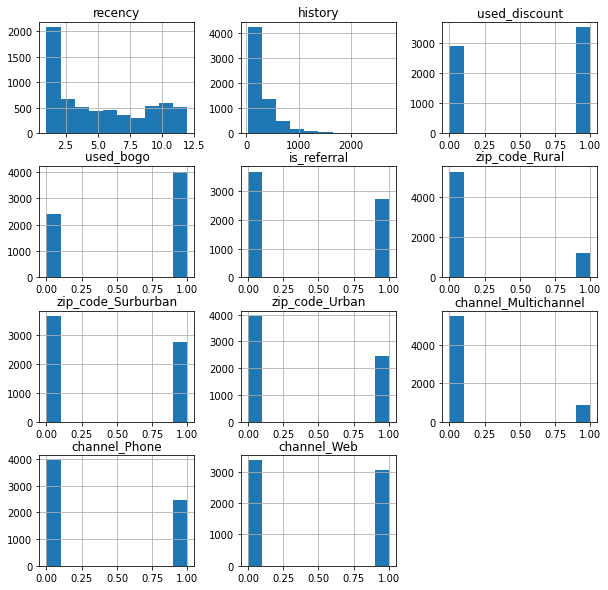

In [6]:
def histogram1(train_data):
  train_data[(train_data['treatment']!=0) & (train_data['target']==1)][features].hist(figsize=(10,10));
histogram1(df_train)

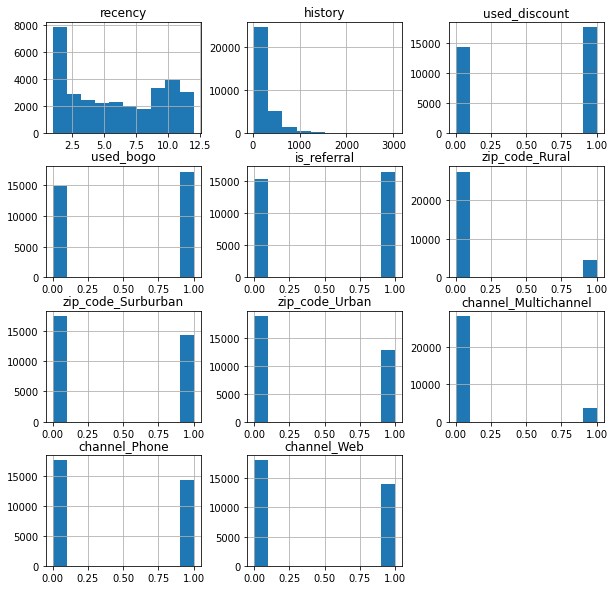

In [7]:
def histogram2(train_data):
  train_data[(train_data['treatment']!=0) & (train_data['target']==0)][features].hist(figsize=(10,10));
histogram2(df_train)

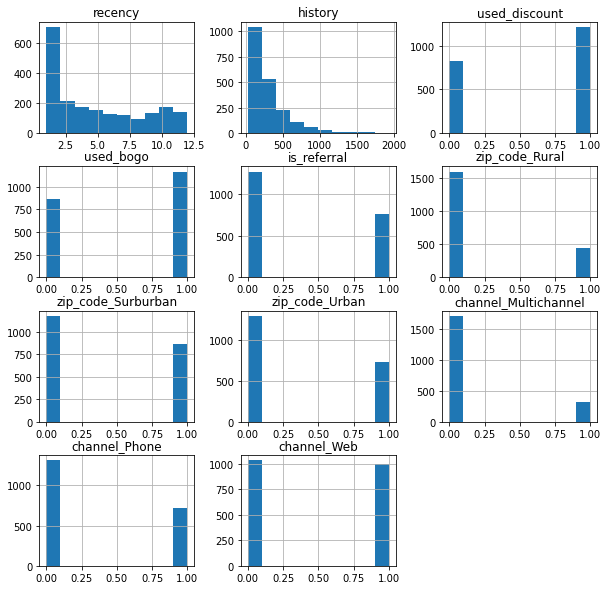

In [8]:
def histogram3(train_data):
  train_data[(train_data['treatment']==0) & (train_data['target']==1)][features].hist(figsize=(10,10));
histogram3(df_train)

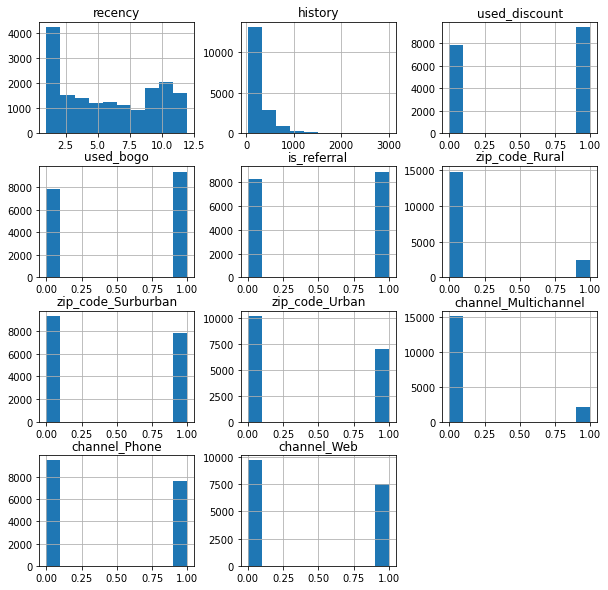

In [9]:
def histogram4(train_data):
  train_data[(train_data['treatment']==0) & (train_data['target']==0)][features].hist(figsize=(10,10));
histogram4(df_train)

In [10]:
df_train.treatment.value_counts()

1    38388
0    19212
Name: treatment, dtype: int64

In [11]:
df_train.target.value_counts()

0    49145
1     8455
Name: target, dtype: int64

In [12]:
df_test.treatment.value_counts()

1    4306
0    2094
Name: treatment, dtype: int64

In [13]:
df_test.target.value_counts()

0    5461
1     939
Name: target, dtype: int64

In [14]:
def promotion_strategy(df):
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [15]:
test_results(promotion_strategy, df_train)

38388 19212
Your irr with this strategy is 0.0616.

Your nir with this strategy is 38151.80.


(0.06155068303212856, 38151.8)

In [16]:
test_results(promotion_strategy, df_test)

4306 2094
Your irr with this strategy is 0.0548.

Your nir with this strategy is 4144.10.


(0.05481633987536992, 4144.1)

In [17]:
response = []

for index, row in df_train.iterrows():
    if (row['target'] == 1) and (row['treatment']==1):
        response.append(1.0)
    else:
        response.append(0.0)
        
df_train['response'] = response
df_train

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,target,response
10954,12,249.19,1,0,0,0,0,1,0,1,0,0,0,0.0
39682,10,104.04,1,0,0,1,0,0,1,0,0,1,0,0.0
521,1,1515.82,1,1,1,1,0,1,0,1,0,0,1,1.0
15569,2,29.99,1,0,1,1,0,1,0,0,1,0,0,0.0
31460,12,29.99,1,0,0,1,0,1,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42046,2,29.99,0,1,1,1,0,0,1,0,0,1,0,0.0
3437,11,256.08,0,1,1,1,0,1,0,0,0,1,0,0.0
1696,11,385.44,0,1,0,1,0,1,0,0,0,1,1,1.0
27103,5,37.87,0,1,1,0,0,0,1,0,0,1,0,0.0


In [18]:
train, valid = sk.model_selection.train_test_split(df_train, test_size=0.2,random_state=42, stratify=df_train.target)

In [19]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

In [20]:
Y_train.value_counts()

0.0    40955
1.0     5125
Name: response, dtype: int64

In [21]:
Y_valid.value_counts()

0.0    10222
1.0     1298
Name: response, dtype: int64

In [22]:

# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [23]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.870391	validation_1-auc:0.565878
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.883519	validation_1-auc:0.568454
[2]	validation_0-auc:0.884713	validation_1-auc:0.571194
[3]	validation_0-auc:0.891027	validation_1-auc:0.569992
[4]	validation_0-auc:0.897214	validation_1-auc:0.571875
[5]	validation_0-auc:0.90218	validation_1-auc:0.571838
[6]	validation_0-auc:0.908308	validation_1-auc:0.572569
[7]	validation_0-auc:0.91063	validation_1-auc:0.57281
[8]	validation_0-auc:0.913348	validation_1-auc:0.572216
[9]	validation_0-auc:0.915227	validation_1-auc:0.572833
[10]	validation_0-auc:0.917968	validation_1-auc:0.572911
[11]	validation_0-auc:0.918374	validation_1-auc:0.572141
[12]	validation_0-auc:0.919957	validation_1-auc:0.571754
[13]	validation_0-auc:0.921053	validation_1-auc:0.570931
[14]	validation_0-auc:0.92283	validation_1-auc:0.570283
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

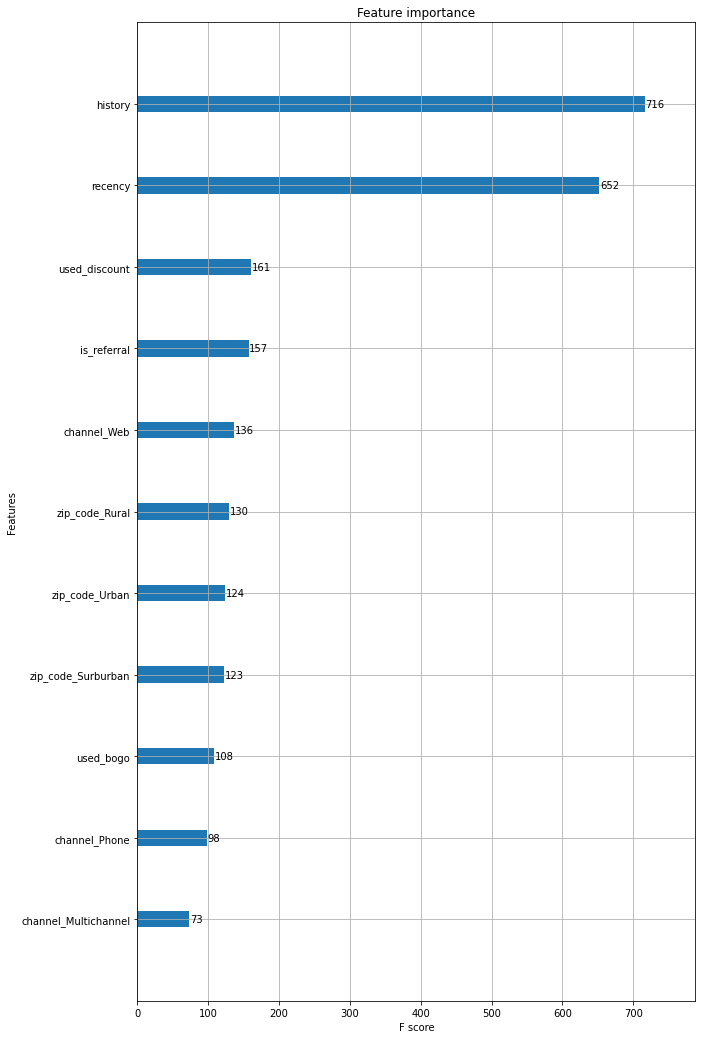

In [24]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [25]:

# confusion matrix
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[10025,   197],
       [ 1266,    32]])

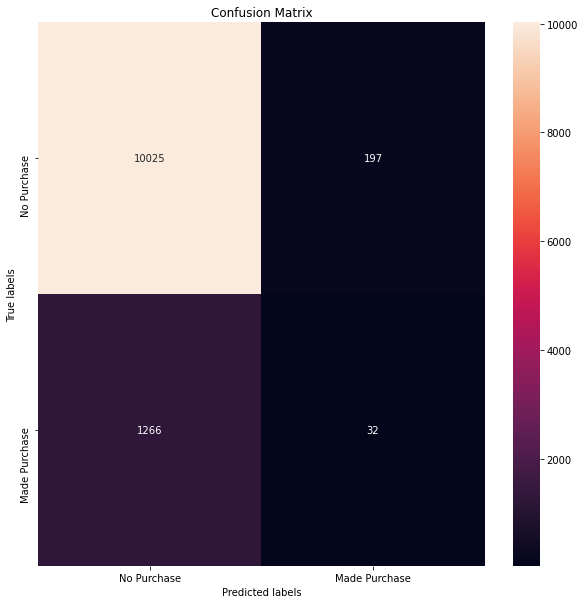

In [26]:
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [27]:
def promotion_strategy(df):

    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
         promotion.append('Yes')
        else:
          promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [28]:
valid_results(promotion_strategy, valid)

157 72
Your irr with this strategy is 0.1066.

Your nir with this strategy is 226.45.


(0.1065994338287332, 226.45)

In [29]:

target = []
for index, row in df_train.iterrows():
    if (row['treatment'] == 1) & (row['target'] == 1):
        # TR group
        target.append(0)
    elif (row['treatment'] == 0) & (row['target'] == 1):
        # CR group
        target.append(1)
    elif (row['treatment'] == 1) & (row['target'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

df_train['target'] = target
print(len(df_train[df_train['target']==0]))
print(len(df_train[df_train['target']==1]))
print(len(df_train[df_train['target']==2]))
print(len(df_train[df_train['target']==3]))

6423
2032
31965
17180


In [30]:

train, valid = sk.model_selection.train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train.target)

features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Multichannel', 'channel_Phone', 'channel_Web']

Y_train = train['target']
X_train = train[features]

Y_valid = valid['target']
X_valid = valid[features]

In [31]:
Y_train.value_counts()

2    25572
3    13744
0     5138
1     1626
Name: target, dtype: int64

In [32]:
Y_valid.value_counts()

2    6393
3    3436
0    1285
1     406
Name: target, dtype: int64

In [33]:
# up sample with SMOTE
sm = SMOTE({0:25572, 1:25572, 2:25572, 3:25572}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3    25572
2    25572
1    25572
0    25572
dtype: int64

In [34]:

eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          num_class=4,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[0]	validation_0-mlogloss:1.35535	validation_1-mlogloss:1.35901
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.32873	validation_1-mlogloss:1.3353
[2]	validation_0-mlogloss:1.30469	validation_1-mlogloss:1.31392
[3]	validation_0-mlogloss:1.28347	validation_1-mlogloss:1.29494
[4]	validation_0-mlogloss:1.26425	validation_1-mlogloss:1.27796
[5]	validation_0-mlogloss:1.24664	validation_1-mlogloss:1.26252
[6]	validation_0-mlogloss:1.23067	validation_1-mlogloss:1.24899
[7]	validation_0-mlogloss:1.21606	validation_1-mlogloss:1.23626
[8]	validation_0-mlogloss:1.20279	validation_1-mlogloss:1.22482
[9]	validation_0-mlogloss:1.18974	validation_1-mlogloss:1.21409
[10]	validation_0-mlogloss:1.17787	validation_1-mlogloss:1.20403
[11]	validation_0-mlogloss:1.16714	validation_1-mlogloss:1.19524
[12]	validation_0-mlogloss:1.15629	validation_1-mlogloss:1.18674

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=True, subsample=1, verbosity=1)

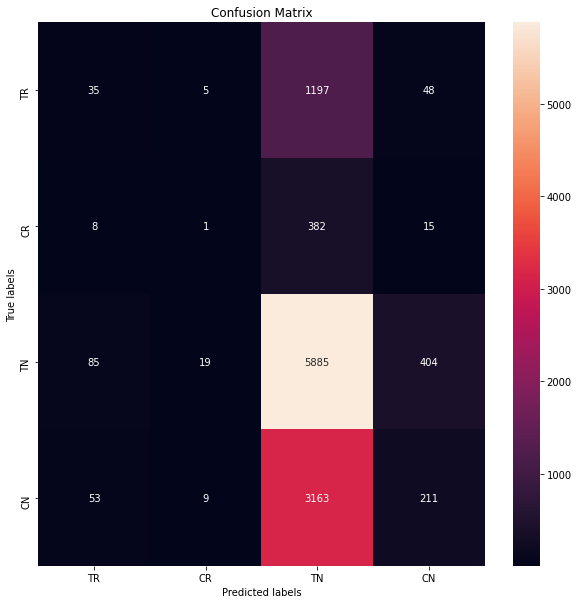

In [35]:
# confusion marix for thge validation set
# Note:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

In [36]:
def promotion_strategy(df):
    test = df
    
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    
    promotion = []
    
    for pred in pred:
        if pred == 0:
            promotion.append('Yes')
        else:
            promotion.append('No')
    
    promotion = np.array(promotion)
    
    return promotion

In [37]:
valid_results(promotion_strategy, valid)


120 61
Your irr with this strategy is -1.3210.

Your nir with this strategy is 12.00.


(-1.3210382513661203, 12.0)

In [38]:
test_results(promotion_strategy, df_test)

80 41
Your irr with this strategy is 0.0299.

Your nir with this strategy is 88.00.


(0.029878048780487804, 88.0)